## Black Friday Sales Prediction
This notebook is on the Black Friday Sales Prediction Hackathon on [Analytics Vidhya](https://datahack.analyticsvidhya.com/contest/black-friday/).
We are going to build a model to predict how much a user will buy and on which product.

**Importing Libraries**

In [1]:
import pandas as pd
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_absolute_error
import warnings
warnings.filterwarnings('ignore')


**Loading files into Pandas Dataframe**

In [2]:
train = pd.read_csv('Train.csv')
test = pd.read_csv('Test.csv')
sample = pd.read_csv('sample_submission.csv')

### Basic Exploratory Data Analysis

In [3]:
train.head()

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
0,1000001,P00069042,F,0-17,10,A,2,0,3,NaN,NaN,8370
1,1000001,P00248942,F,0-17,10,A,2,0,1,6.0,14.0,15200
2,1000001,P00087842,F,0-17,10,A,2,0,12,NaN,NaN,1422
3,1000001,P00085442,F,0-17,10,A,2,0,12,14.0,NaN,1057
4,1000002,P00285442,M,55+,16,C,4+,0,8,NaN,NaN,7969


In [4]:
test.head()

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3
0,1000004,P00128942,M,46-50,7,B,2,1,1,11.0,NaN
1,1000009,P00113442,M,26-35,17,C,0,0,3,5.0,NaN
2,1000010,P00288442,F,36-45,1,B,4+,1,5,14.0,NaN
3,1000010,P00145342,F,36-45,1,B,4+,1,4,9.0,NaN
4,1000011,P00053842,F,26-35,1,C,1,0,4,5.0,12.0


In [5]:
sample.head() # this is how our submission file to the competition should look like

,Purchase,User_ID,Product_ID
0,100,1000004,P00128942
1,100,1000009,P00113442
2,100,1000010,P00288442
3,100,1000010,P00145342
4,100,1000011,P00053842


In [6]:
# let's check the number of rows and columns in the train and test dataset
print(f'Shape of train set: {train.shape} \nShape of test set: {test.shape}')

Shape of train set: (550068, 12) 
Shape of test set: (233599, 11)


In [7]:
train.isnull().sum().sort_values()

User_ID                            0
Product_ID                         0
Gender                             0
Age                                0
Occupation                         0
City_Category                      0
Stay_In_Current_City_Years         0
Marital_Status                     0
Product_Category_1                 0
Purchase                           0
Product_Category_2            173638
Product_Category_3            383247
dtype: int64

In [8]:
test.isnull().sum().sort_values()

User_ID                            0
Product_ID                         0
Gender                             0
Age                                0
Occupation                         0
City_Category                      0
Stay_In_Current_City_Years         0
Marital_Status                     0
Product_Category_1                 0
Product_Category_2             72344
Product_Category_3            162562
dtype: int64

In [9]:
train.describe()

,User_ID,Occupation,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
count,5.500680e+05,550068.000000,550068.000000,550068.000000,376430.000000,166821.000000,550068.000000
mean,1.003029e+06,8.076707,0.409653,5.404270,9.842329,12.668243,9263.968713
std,1.727592e+03,6.522660,0.491770,3.936211,5.086590,4.125338,5023.065394
min,1.000001e+06,0.000000,0.000000,1.000000,2.000000,3.000000,12.000000
25%,1.001516e+06,2.000000,0.000000,1.000000,5.000000,9.000000,5823.000000
50%,1.003077e+06,7.000000,0.000000,5.000000,9.000000,14.000000,8047.000000
75%,1.004478e+06,14.000000,1.000000,8.000000,15.000000,16.000000,12054.000000
max,1.006040e+06,20.000000,1.000000,20.000000,18.000000,18.000000,23961.000000


In [10]:
test.describe()

,User_ID,Occupation,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3
count,2.335990e+05,233599.000000,233599.000000,233599.000000,161255.000000,71037.000000
mean,1.003029e+06,8.085407,0.410070,5.276542,9.849586,12.669454
std,1.726505e+03,6.521146,0.491847,3.736380,5.094943,4.125944
min,1.000001e+06,0.000000,0.000000,1.000000,2.000000,3.000000
25%,1.001527e+06,2.000000,0.000000,1.000000,5.000000,9.000000
50%,1.003070e+06,7.000000,0.000000,5.000000,9.000000,14.000000
75%,1.004477e+06,14.000000,1.000000,8.000000,15.000000,16.000000
max,1.006040e+06,20.000000,1.000000,18.000000,18.000000,18.000000


In [11]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 550068 entries, 0 to 550067
Data columns (total 12 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   User_ID                     550068 non-null  int64  
 1   Product_ID                  550068 non-null  object 
 2   Gender                      550068 non-null  object 
 3   Age                         550068 non-null  object 
 4   Occupation                  550068 non-null  int64  
 5   City_Category               550068 non-null  object 
 6   Stay_In_Current_City_Years  550068 non-null  object 
 7   Marital_Status              550068 non-null  int64  
 8   Product_Category_1          550068 non-null  int64  
 9   Product_Category_2          376430 non-null  float64
 10  Product_Category_3          166821 non-null  float64
 11  Purchase                    550068 non-null  int64  
dtypes: float64(2), int64(5), object(5)
memory usage: 50.4+ MB


In [12]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 233599 entries, 0 to 233598
Data columns (total 11 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   User_ID                     233599 non-null  int64  
 1   Product_ID                  233599 non-null  object 
 2   Gender                      233599 non-null  object 
 3   Age                         233599 non-null  object 
 4   Occupation                  233599 non-null  int64  
 5   City_Category               233599 non-null  object 
 6   Stay_In_Current_City_Years  233599 non-null  object 
 7   Marital_Status              233599 non-null  int64  
 8   Product_Category_1          233599 non-null  int64  
 9   Product_Category_2          161255 non-null  float64
 10  Product_Category_3          71037 non-null   float64
dtypes: float64(2), int64(4), object(5)
memory usage: 19.6+ MB


In [13]:
train.columns

Index(['User_ID', 'Product_ID', 'Gender', 'Age', 'Occupation', 'City_Category',
       'Stay_In_Current_City_Years', 'Marital_Status', 'Product_Category_1',
       'Product_Category_2', 'Product_Category_3', 'Purchase'],
      dtype='object')

**Let's see which gender makes the most purchase**

Text(0, 0.5, 'Purchase')

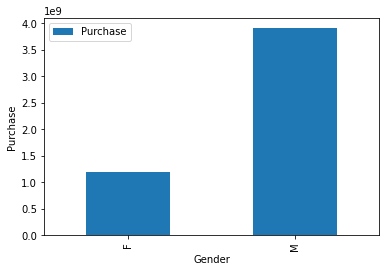

In [14]:
gender_df = train.groupby(train['Gender']).sum().filter(items=['Purchase'])
plot = gender_df.plot(kind="bar")
plot.set_ylabel("Purchase")

**The age group that makes the most purchases**

Text(0, 0.5, 'Age')

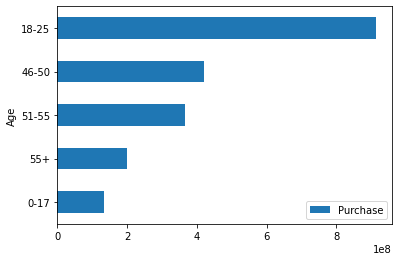

In [15]:
age_df = train.groupby(train['Age']).sum().sort_values("Purchase").filter(items=['Purchase']).head()
plot = age_df.plot(kind="barh")
plot.set_ylabel("Age")


## Preprocessing, Fitting and Model Validation

In [16]:
# Remove rows with missing target, separate target from predictors
train.dropna(axis=0, subset=['Purchase'], inplace=True)
y = train.Purchase
train.drop(['Purchase'], axis=1, inplace=True)

# Break off validation set from training data
X_train_full, X_valid_full, y_train, y_valid = train_test_split(train, y, 
                                                                train_size=0.8, test_size=0.2,
                                                                random_state=0)

main_cols = X_train_full.columns.difference(['User_ID', 'Product_ID'])
# Select categorical columns 
categorical_cols = [cname for cname in X_train_full.columns if
                    X_train_full[cname].dtype == "object" 
                    and cname in main_cols]

# Select numerical columns
numerical_cols = [cname for cname in X_train_full.columns if 
                X_train_full[cname].dtype in ['int64', 'float64'] and cname in main_cols]

# Keep selected columns only
my_cols = categorical_cols + numerical_cols
X_train = X_train_full[my_cols].copy()
X_valid = X_valid_full[my_cols].copy()
X_test = test[my_cols].copy()

In [17]:
X_train.head()

,Gender,Age,City_Category,Stay_In_Current_City_Years,Occupation,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3
401980,M,26-35,C,4+,7,1,8,NaN,NaN
368189,M,26-35,B,2,14,0,8,17.0,NaN
181444,M,18-25,C,4+,7,0,8,NaN,NaN
238822,M,18-25,A,4+,20,1,5,8.0,NaN
127422,F,55+,C,4+,0,0,5,NaN,NaN


In [18]:
# Preprocessing for numerical data
numerical_transformer = SimpleImputer(strategy='mean')

# Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')), 
                                          ('onehot', OneHotEncoder(handle_unknown='ignore'))])

# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
                ])

In [19]:
# Define model
model = XGBRegressor(n_estimators=1000, learning_rate=0.05) 

# Bundle preprocessing and modeling code in a pipeline
my_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('model', model)
                             ])

In [20]:
# Preprocessing of training data, fit model 
my_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', SimpleImputer(),
                                                  ['Occupation',
                                                   'Marital_Status',
                                                   'Product_Category_1',
                                                   'Product_Category_2',
                                                   'Product_Category_3']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Gender', 'Age',
                                       

In [21]:
# Preprocessing of validation data, get predictions
preds = my_pipeline.predict(X_valid)

In [22]:
# Evaluate the model
score = mean_absolute_error(y_valid, preds)
print('MAE:', score)

MAE: 2131.7816602215885


In [23]:
# Preprocessing of test data, fit model
preds_test = my_pipeline.predict(X_test)

**Submission File**

In [24]:
#check if ID in test is same Sample submission file given
print(set(test.User_ID == sample.User_ID))
print(set(test.Product_ID == sample.Product_ID))

{True}
{True}


In [25]:
# Create a submission file and replace target variable
sub_file = sample.copy()
sub_file.Purchase = preds_test


In [26]:
# Create a csv file and upload to Analytics Vidhya
sub_file.to_csv('submission.csv', index = False)